# Simple Genetic Algorithm
Given a population, we select only the top $f$ fraction of members. The rest are decimated.

Then, to get the remaining population for the next generation, to create each _child_, we cross over two randomly selected _parents_ with either passing on their parameters with equal chance.

A Gaussian noise with fixed deviation is also added.

In code:
```python
def ga(population):
    fitness = list(map(evaluator, population))
    fitness_ids = argsort(fitness)
    
    surviving_ids = fitness_ids[-int(surviving_fraction * len(population)):]
    survivors = population[surviving_ids]
    
    def _breed(father, mother):
        mask = torch.bernoulli(torch.ones(len(father)) * 0.5).float()
        return father * mask + mother * (1 - mask)
    
    breeding_mates = [np.random.randint(0, len(survivors), 2)
                      for _ in range(len(population) - len(survivors))]
    breeding_mates = [[survivors[i[0]], survivors[i[1]]]
                      for i in breeding_mates]
    children = [_breed(*mates) for mates in breeding_mates]
    new_population = survivors + children
    return new_population
```

# Setup

## Imports

In [1]:
import gym

Torch Modules

In [2]:
import torch

from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
from functools import partial
from tqdm import tqdm_notebook as tqdm

from concurrent.futures import ProcessPoolExecutor

In [4]:
from utils.environment import add_energy, make_specs, run_env
from utils.model import get_params, set_params, get_action
from utils.genetic import ES

## Define Useful Features

In [5]:
jtplot_style()

## Load Environment

In [6]:
env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
make_specs(env)
n_obs = env.spec.n_obs
n_act = env.spec.n_act

In [8]:
add_energy(env)

# Create Model

In [9]:
get_model = lambda: nn.Linear(n_obs, n_act)

In [10]:
model = get_model()

# Create GA

In [11]:
class SimpleGA(ES):
    def __init__(self, evaluator, population_size, mean, surviving_fraction=0.1, std=1e-3):
        super().__init__(population_size)
        self._evaluator = evaluator
        self._surviving_size = max(2, int(surviving_fraction * population_size))
        self._std = std
        self._population = [mean + torch.randn(len(mean)) 
                            for _ in range(population_size)]
        self._history.append((0, evaluator(mean)))
        
    def _strategy(self, num_workers):
        with ProcessPoolExecutor(num_workers) as executor: 
            fitnesses = list(executor.map(self._evaluator, self._population))
            
        fitness_ids = np.argsort(fitnesses)
        surviving_ids = fitness_ids[-self._surviving_size:]
        survivors = [self._population[i] for i in surviving_ids]
        
        def _breed(father, mother):
            mask = torch.bernoulli(torch.ones(len(father)) * 0.5).float()
            noise = torch.randn(len(father)) * self._std
            
            return father * mask + mother * (1 - mask) + noise
        
        def _random_choice(a, size, replace=True, p=None):
            ids = np.random.choice(np.arange(len(a)), size, replace, p)
            return [a[i] for i in ids]
        
        breeding_mates = [_random_choice(survivors, 2, replace=False)
                          for _ in range(len(self._population) - len(survivors))]
        children = [_breed(*mates) for mates in breeding_mates]
        
        new_population = survivors + children
        
        fitness = fitnesses[surviving_ids[-1]]
        self._solution = survivors[-1]
        
        return new_population, fitness
    
    def solution(self):
        return self._solution

In [12]:
def evaluator(params, gamma=0, episodes=1):
    model = get_model()
    set_params(model, params)
    rewards, energies = run_env(env, lambda x: get_action(model, x), episodes)
    return rewards - gamma * energies

In [13]:
solver = SimpleGA(partial(evaluator, gamma=0.0, episodes=1), 5,
                  torch.zeros(len(get_params(model))))

In [14]:
solver(30)

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

-92.000


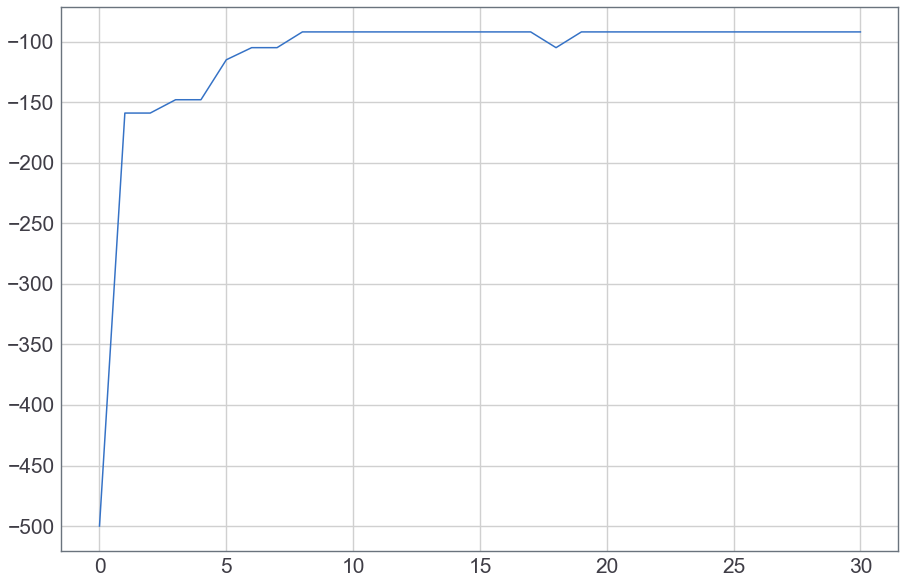

In [15]:
solver.plot_history()

In [16]:
set_params(model, solver.solution())

# Sample Model

In [17]:
run_env(env, lambda x: get_action(model, x, probabilistic=True), 5, render=True)

(-577.0, 0)